# Exercises Week 11-12: Graded exercise session (part B)

**Course**: [Topics in life sciences engineering](https://moodle.epfl.ch/enrol/index.php?id=17061) (BIO-411)

**Professors**:  _Gönczy Pierre_, _Naef Felix_, _McCabe Brian Donal_

In [84]:
## Import libraries
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import gseapy as gp
import math


from scipy.integrate import odeint
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from adjustText import adjust_text
from scipy.stats import beta

**Provide answers in the form of code, figures (if relevant) and short descriptions (in markdown cells) in those notebooks. Submit your notebook to Moodle, please make sure to execute every cell.**

### Exercise 1: Simulation of circadian gene regulation

Similarly to Week 9 exercises, we first describe a system in which a (nuclear) pre-mRNA is transcribed and spliced to produce an mRNA. We can write a 2D ODE (ignoring the degradation of the pre-mRNA):

\begin{eqnarray*}
&&\frac{dP}{dt} = s(t) - \rho P \\
&&\frac{dM}{dt} = \rho P - k(t) M \\
\end{eqnarray*}

Here, $P$ and $M$ denote, respectively, the concentrations of pre-mRNA and mRNA. We will consider time-dependent (circadian) transcription and degradation rates. The frequency is $\omega=\frac{2\pi}{T}$ with $T=24h$. $s(t)$ is the transcription rate, which is now taken either as constant $s(t)=s_{0}$ or as a rhythmic function of time:  

\begin{equation*}
s(t) = s_0 (1 + \epsilon_s \cos(\omega t)) 
\end{equation*}  
with relative amplitude $0\leq \epsilon_s\leq 1$. Note that here the peak of $s(t)$ is at $t=0$. 
Similarly, we will consider $k(t)$ either as constant $k(t)= k_0$ or a rhythmic function of time:  
\begin{equation*}
k(t)=k_0(1 + \epsilon_k \cos(\omega (t-t_k))
\end{equation*}  
with $0\leq\epsilon_k\leq 1$, and the maximum degradation rate at $t=t_k$.

$\rho$ is the splicing rate of pre-mRNA $P$ to mRNA $M$, and is also taken as a constant.

### Question 1
1. Adapt the code of week 9 exercises to simulate this new system. Modify the interactive widget such that you can vary the new parameters and plot $P(t)$ and $M(t)$.  
2. Keep the degradation rate constant ($\epsilon_k$=0) and vary $k_0$ and $\epsilon_s$. Discuss on how 1) the phase delay between $M(t)$ and $P(t)$ and 2) the relative amplitude of $M(t)$ varies in function of $k_0$. What is the maximal relative amplitude? Make sure you span a relevant range for $k_0^{-1}$ ( *i.e.* from 10 minutes to several hours).
3. Vary $\epsilon_k$ to include rhythmic degradation. Discuss the different effects, in particular, find situations that extend beyond what is possible with a constant half-life. See also [Wang et al., 2018](https://www.pnas.org/doi/10.1073/pnas.1715225115).

## Answer 1 

#### 1. See the cell below for our code adaptation

In [85]:
def transcription_rate(s0,eps_s,t) :
    return s0*(1+ eps_s*np.cos(2*t*math.pi/(24)))

def degradation_rate(k0,eps_k,t,tk) :
    return k0*(1+ eps_k*np.cos((2*math.pi/(24))*(t-tk)))

## function definition
def func(y, t, tk, s0, k0, eps_s, eps_k, rho):
    P, M = y
    return [transcription_rate(s0,eps_s,t) - (rho) * P, rho * P - degradation_rate(k0,eps_k,t,tk) * M]


def simulation(func, par, x0 = None, t = None):
    s0=par['s0']
    k0=par['k0']
    tk = par['tk']
    eps_s=par['eps_s']
    eps_k=par['eps_k']
    rho=par['rho']

    P_ss = transcription_rate(s0,eps_s,t)/(rho) #Steady-state solution for P
    M_ss = transcription_rate(s0,eps_s,t)/degradation_rate(k0,eps_k,t,tk) #Steady-state solution for M

    
    xx=odeint(func, x0, t, args=(tk, s0, k0, eps_s, eps_k, rho))
    plt.figure(1)
    plt.ylim([0,150])
    #plt.axhline(y=np.mean(P_ss), color='r', linestyle='--') # Steady state solution mean for P_ss
    #plt.axhline(y=np.mean(M_ss), color='g', linestyle='--') # Steady state solution mean for M_ss
    plt.plot(t, xx[:,0],label = 'P(t)')
    plt.plot(t, xx[:,1],label = 'M(t)')
    plt.xlabel("time [min]")
    plt.ylabel("#molecules")
    plt.legend()
    plt.show()
    
def animate(x0, time, s0=5, k0= 0.05, eps_s=0.5, eps_k=0.5, rho=0.5, tk = 50):
    #define the function domain
    par={'s0':s0,'k0':k0, 'eps_s':eps_s, 'rho':rho,'eps_k': eps_k,'tk':tk}
    simulation(func, par, x0, time)

#initial conditions
z0=[0,0] #[P, M]
t = np.linspace(0,100,1001)
interact(animate, x0=fixed(z0), time=fixed(t), 
         s0 = (1,10,0.01), #kp^1 in [10 min, 120 min] 
         k0 = (1/360,1/10,1/1000), #km^1 in [10 min, 5000 min]
         rho = (1/30,1,0.05), #rho^1 in [1 min, 30 min]
         eps_s =(0,1,0.01),
         eps_k = (0,1,0.01),
         tk = (0,100,0.001));

interactive(children=(FloatSlider(value=5.0, description='s0', max=10.0, min=1.0, step=0.01), FloatSlider(valu…

### 2.a Discussion
First, we thus keep the degradation rate $\epsilon_k$=0 and we play with the $\epsilon_s$ and $k_0$ values.

By keeping $\epsilon_k$=0, the degradation rate of our mRNA is therefore only to $k_0$, which is a constant. Therefore, we can see when changing the $k_0$ value above that the quantity of mRNA in function of time, M(t) is changing a lot as well. However, P(t) does not change at all when playing with the parameters in these conditions, as it does not depend on the degradation rate.

More precisely, we can observe that increasing the $k_0$ will cause our M(t) to decrease, as it means mRNA tends to be degraded faster. In this case, our M(t) function seems to be reaching an oscillating behaviour around a mean value, which depends on the $\rho$ and $s_0$ parameters.  This will also cause the amplitude of M(t) oscillations to be larger as $k_0$ decreases.

On the other hand, decreasing $k_0$ will make M(t) grow indefinitely (or at least it seems, as our figure does not allow us to see what happens at huge values of M(t)), when decreasing $k_0$ a lot (under 0.03). M(t) will still be reduced periodically, but by a very small margin compared to the increase due to reducing $k_0$, thus inducing a general trend of increasing mRNA quantities.

### 2.b Amplitudes & phase

We can conclude that the phase delay between M(t) and P(t) does not change when varying $k_0$, as our degradation rate is a constant and does not depend on time in these conditions.

The maximum relative amplitude is thus obtained for high values of $k_0$ and, in our case, seem to be reaching a factor 2 between M(t) and P(t).



### 3. Including rythmic degradation.

Let us summarize how the different parameters change the behaviour of M(t) and P(t) now that we've included rythmic degradation in our model :

- $s_0$, $\rho$ and $\epsilon_s$ vary the general amounts of M(t) as well as of P(t). $\rho$, the splicing rate, will increase the mRNA quantities if it is high, and decrease the mRNA quantities if it is low. It thus does the opposite for P(t). Varying $s_0$ will make both M(t) and P(t) larger or smaller, as well as increasing/decreasing the oscillations amplitude in the same way. $\epsilon_s$, the transcription rate, will only increase or decrease the oscillations, as for a $\epsilon_s$ = 0 for instance, the transcription will be constant and no oscillations will thus appear on our graph


- $\epsilon_k$ : Only has an effect on M(t), as previously said. Large values of $\epsilon_k$ increase the M(t) oscillations amplitude (if $k_0$ is large enough), while small values of $\epsilon_k$ do the opposite. Also acts with $t_k$ to change the phase delay between P(t) and M(t)(the phase delay will change more or less with for different values of $\epsilon_k$ depending on $t_k$, see below )


- $k_0$ : Same effects as in the discussion above.


- $t_k$ : Will affect the phase delay between M(t) and P(t) by acting on the rythmic degradation rate k(t). When all other values are set and $k_0$ is high enough, varying $t_k$ will thus modify the behaviour of the M(t) oscillations, by varying their amplitude as well as the phase delay with P(t).

### find situations that extend beyond what is possible with a constant half-life?


### Exercise 2: Circadian (post-)transcriptional regulation of gene expression in mouse liver

We will now analyse published RNA-seq data from mouse liver under an *ad libitum* feeding regimen and in presence of a 12h-12h light-dark cycle ([Atger et al., 2015](https://www.pnas.org/doi/abs/10.1073/pnas.1515308112)). The samples were harvested every 2 hours in four replicates, RNA was extracted and sequenced. Similarly to week 9 exercises on RNA-seq data, gene expression was quantified at the intron and exon levels. Note that data are $log_2$ transformed and normalized (RPKM).

### Question 1
1. Adapt code from week 9 exercises to perform PCA using the 14 following genes (core clock genes and selected clock output genes): ``['Arntl', 'Npas2', 'Clock', 'Cry1', 'Cry2', 'Per1', 'Per2', 'Per3', 'Nr1d1', 'Nr1d2', 'Rora', 'Rorc', 'Tef', 'Dbp']``. First start with only the exons, then only the introns, and eventually both. Describe your observations.
2. Using the *return_amp_phase_pv* function with the $log_2$ data, assess rhythmicity genome-wide (use the p-value to make gene selections). For the selected genes, provide histograms of the peak times, and amplitudes ($log_2$ peak-to-trough). Do this separately for the exons and introns. Do you see what's commonly referred to as the morning and evening waves of genes expression?
3. Which genes are overall the most robustly rhythmic? Is there a theme?
3. Adapting the enrichR code from Week 9 exercises, find biological function or transcriptional programs regulated rhythmically in the mouse liver. Do this separately for the night and the day. Comment.

### Answer 1 :

#### The cells below run PCA on introns, exons and then introns + exons

In [86]:
dat = pd.read_csv("./GSE73554_WT_AL_Intron_Exon_RFP.txt",sep='\t')
dat.index = dat['Gene_Symbol']
dat = dat.drop(['Gene_Symbol','Gene_Ensembl'], axis=1)
dat.columns = dat.columns.str.split('_', expand = True)
dat.columns.names = ['condition','feeding','feature','time','replicate']

In [87]:
# get only the genes we're interested in
genes = ['Arntl', 'Npas2', 'Clock', 'Cry1', 'Cry2', 'Per1', 'Per2', 'Per3', 'Nr1d1', 'Nr1d2', 'Rora', 'Rorc', 'Tef', 'Dbp']
all_dat = dat
dat = dat.loc[genes]
i_introns = dat.columns.get_level_values('feature').isin(['Intron'])
dat_intron = dat.iloc[:,i_introns]
i_exons = dat.columns.get_level_values('feature').isin(['Exon'])
dat_exons = dat.iloc[:,i_exons]

i_all = dat.columns.get_level_values('feature').isin(['Intron', 'Exon'])
dat_tot = dat.iloc[:,i_all]

In [88]:
def run_PCA(data, nc=5, x_1=1, x_2=2, col='replicate', shape='time', scale_d=True, log=True):
    pca = PCA(n_components=nc)
    x_1=x_1-1
    x_2=x_2-1
    
    #print(data)

    if(scale_d):
        data_2 = scale(data)
        #print(data_2)
    else:
        data_2 = data

    if(log):
        data_2 =  np.log2(data_2 + 1)
  
    pca.fit(data_2.T)

    labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
    }


    ## compute PCA and plot
    pca_transformed = pca.transform(data_2.T)
    fig = px.scatter(pca_transformed, x=x_1, y=x_2,
                     color=data.columns.get_level_values(col),
                     symbol=data.columns.get_level_values(shape),
                     width=600, height=600)

    fig.update_traces(marker={'size': 13})
    fig.update_layout(plot_bgcolor = 'rgb(243,243,243)', xaxis_title=labels[str(x_1)],
                      yaxis_title=labels[str(x_2)])
    fig.show()

    df_pca= pd.DataFrame(pca.components_, columns=data.index, index = ['PC-1','PC-2','PC-3','PC-4','PC-5']);

    return df_pca

In [89]:
#Perform the PCA on introns
pca_introns = run_PCA(dat_intron, x_1=1, x_2=2, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_intron, x_1=1, x_2=2, col='replicate', shape='feature', scale_d=True, log=False);

run_PCA(dat_intron, x_1=2, x_2=3, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_intron, x_1=2, x_2=3, col='replicate', shape='feature', scale_d=True, log=False);

run_PCA(dat_intron, x_1=3, x_2=4, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_intron, x_1=3, x_2=4, col='replicate', shape='feature', scale_d=True, log=False);

In [90]:
#Perform the PCA on exons
pca_exons = run_PCA(dat_exons, x_1=1, x_2=2, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_exons, x_1=1, x_2=2, col='replicate', shape='feature', scale_d=True, log=False);

run_PCA(dat_exons, x_1=2, x_2=3, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_exons, x_1=2, x_2=3, col='replicate', shape='feature', scale_d=True, log=False);

run_PCA(dat_exons, x_1=3, x_2=4, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_exons, x_1=3, x_2=4, col='replicate', shape='feature', scale_d=True, log=False);

In [91]:
#Perform the PCA on exons + introns
pca_all = run_PCA(dat_tot, x_1=1, x_2=2, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_tot, x_1=1, x_2=2, col='replicate', shape='feature', scale_d=True, log=False);

run_PCA(dat_tot, x_1=2, x_2=3, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_tot, x_1=2, x_2=3, col='replicate', shape='feature', scale_d=True, log=False);

run_PCA(dat_tot, x_1=3, x_2=4, col='time', shape='condition', scale_d=True, log=False);
run_PCA(dat_tot, x_1=3, x_2=4, col='replicate', shape='feature', scale_d=True, log=False);

### 1. PCA experiments

In both our exons-only and introns-only PCA experiments, some interesting and similar behaviours can be observed. 
The PC1 vs PC2 graphs in these two experiments show a rythmic behaviour of those two components with time, a rythmicity that is respected when looking at our PC1 vs PC2 graph in the case of replicates, which show the exact same behaviour.

More precisely, the PC1 vs PC2 values indeed seem to make a full circle from time 00 to time 22, indicating a rythmicity in the expression of our genes. As previously said, we can also see that our 4 replicates (A,B,C and D) all follow this "circle" behaviour.

In addition to this rythmicity, by looking at the PCA experiment when using both introns and exons, we can add that the exons and introns values for PC1 vs PC2 or PC3 vs PC4 differ. In the first case (PC1 vs PC2 in the case of replicates), while both exons and introns values follow the rythmicity seen above, exons values seem to be more "extreme"/large than the intron ones, whose circle behaviour seem to have a smaller radius. 
This difference is most blatant in the PC3 vs PC4 or even the PC2 vs PC3 graphs (again, the replicates ones), where there seem to be two clusters, one with the introns values and an other with exons values. 
C'est utile de dire ça / y'a quoi d'autre à dire?

#### Assess rhythmicity

In [92]:
# Function to infer the p-value, phase, amplitude and mean from a time-serie y with size N, period T and sampling Ts. 
def return_amp_phase_pv(y, Ts, T, N):
    
    # we do the harmonic regression using a Fourier series
    t = np.linspace(0.0, N * Ts, N)
    x_fft = np.fft.fft(y)
    freq = np.fft.fftfreq(len(y), d=Ts)
    index, = np.where(np.isclose(freq, 1/T, atol=0.005))
    amp = 4 / N * np.abs(x_fft[index[0]])
    phase = T * np.arctan2(-x_fft[index[0]].imag, x_fft[index[0]].real) / (2 * np.pi)
    mu = 1 / N * x_fft[0].real
    
    #compute the residuals and statistics of the fit (pval)
    x_hat = mu + 0.5 * amp * np.cos(2 * np.pi / T * t - 2 * np.pi * phase / T)
    res = y - x_hat
    sig2_1 = np.var(res)
    sig2 = np.var(y)
    R2 = 1 - sig2_1 / sig2
    p = 3
    pval = 1 - beta.cdf(R2, (p - 1) / 2, (N - p) / 2)
    if phase < 0:
        phase += T
        
    return amp, phase, pval, mu

In [93]:
#Apply the function for all the genes at the intron or exon level and retrieve the amplitude, phase, mean and p-value.

Ts = 2.0 # sampling time 
T = 24 # period
N = 48 # number of samples

amp_intron = []
phase_intron = [] 
pv_intron = []
mu_intron = []

i_pos = all_dat.columns.get_level_values('feature').isin(['Intron'])

for i, row in all_dat.iterrows():
    [a, p, pv, mu] = return_amp_phase_pv(np.array(row)[i_pos], Ts, T, N)
    amp_intron.append(a)
    phase_intron.append(p)
    pv_intron.append(pv)
    mu_intron.append(mu)
    
amp_exon = []
phase_exon = [] 
pv_exon = []
mu_exon = []
e_pos = all_dat.columns.get_level_values('feature').isin(['Exon'])

for i, row in all_dat.iterrows():
    [a, p, pv, mu]=return_amp_phase_pv(np.array(row)[e_pos], Ts, T, N)
    amp_exon.append(a)
    phase_exon.append(p)
    pv_exon.append(pv)
    mu_exon.append(mu)

#convert the lists to numpy arrays
phase_intron=np.array(phase_intron)
amp_intron=np.array(amp_intron)
pv_intron=np.array(pv_intron)
mu_intron=np.array(mu_intron)

phase_exon=np.array(phase_exon)
amp_exon=np.array(amp_exon)
pv_exon=np.array(pv_exon)
mu_exon=np.array(mu_exon)

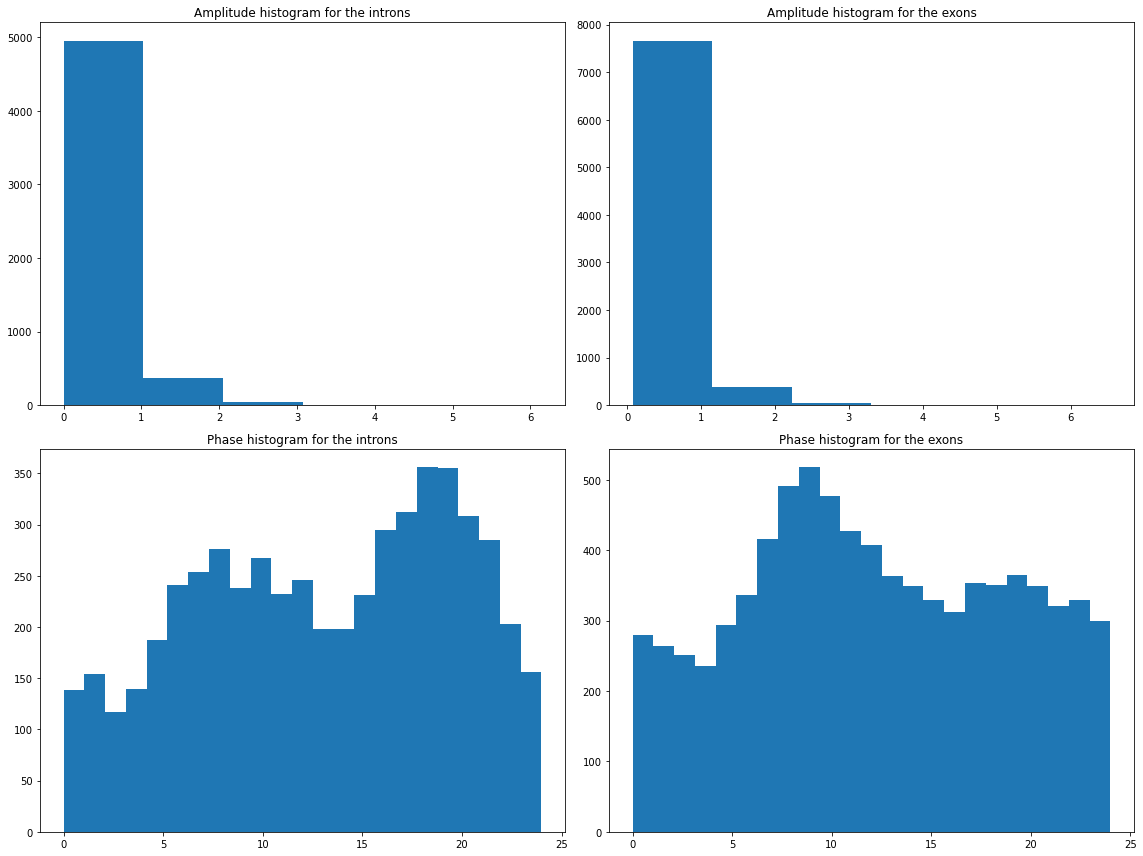

In [94]:
#Selecting only the amplitude/phases of introns & exons that show a p-value < 0.05.

good_introns_amp = amp_intron[pv_intron<0.05]
good_exons_amp = amp_exon[pv_exon<0.05]

good_introns_phase = phase_intron[pv_intron<0.05]
good_exons_phase = phase_exon[pv_exon<0.05]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (16,12))

ax1.hist(good_introns_amp,bins=int(max(good_introns_amp)))
ax1.set_title('Amplitude histogram for the introns')   

ax2.hist(good_exons_amp,bins=int(max(good_exons_amp)))
ax2.set_title('Amplitude histogram for the exons')

ax3.hist(good_introns_phase,bins=int(max(good_introns_phase)));
ax3.set_title('Phase histogram for the introns')

ax4.hist(good_exons_phase,bins=int(max(good_exons_phase)));
ax4.set_title('Phase histogram for the exons')

plt.tight_layout()
plt.show()

### 2. Phase and amplitude histograms

We can indeed observe a wave pattern of gene expression which is particularly noticeable in the phase histograms for the introns, where a peak around 7h~ and another one around 19~ hours can be observed (morning wave and evening wave).

### 3. Robustly rythmic genes

One can assume that the most robust genes regarding their rythmicity will be the ones where difference between maximum and minimum expression levels will be the highest. Indeed, the rythmicity of such genes is probably really crucial and the latter would then be pretty resistant to some changes in their expression.

In our case, we thus simply have to select the genes for which introns/exons amplitude is the highest. By looking at our histograms, we can try and fine the genes for which both introns and exons amplitude is, per say, >2, as it only concern a really small fraction of genes :

In [95]:
### code that does this

Which genes are overall the most robustly rhythmic? Is there a theme? --> on peut sélectionner les gènes comme spécifié au dessus et regarder leur phase ? genre voir si les introns ont une phase différente des exons par exemple

### 4. EnrichR analysis

In [40]:
mouse = gp.get_library_name(organism='Mouse')
print(mouse[0:20])
+pca = run_PCA(all_dat, x_1=1, x_2=2, col='time', shape='condition', scale_d=True, log=False);

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CORUM']


In [56]:
nb_genes = 100
PC = 'PC-1'
bottom = pca.sort_values(by=PC,axis=1).columns[:nb_genes]
top = pca.sort_values(by=PC,axis=1).columns[-nb_genes:]
top_bot = top.union(bottom)# you can use only top or bottom here as well
gene_list = top_bot.to_series().str.upper()
gene_list = gene_list.squeeze().str.strip().to_list()
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets='GO_Biological_Process_2021',
                 organism='mouse', 
                 outdir=None)
display(enr.results.head(10))
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets='WikiPathways_2019_Mouse',
                 organism='mouse', 
                 outdir=None)
display(enr.results.head(10))
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets='ChEA_2022',
                 organism='mouse', 
                 outdir=None)
display(enr.results.head(10))

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,positive regulation of lipoprotein lipase acti...,3/8,0.000053,0.021906,0,0,60.289340,593.377623,APOH;APOA1;APOA5
1,GO_Biological_Process_2021,glutathione derivative biosynthetic process (G...,4/22,0.000062,0.021906,0,0,22.428571,217.428717,GSTM3;GSTA4;GSTA2;GSTA1
2,GO_Biological_Process_2021,glutathione derivative metabolic process (GO:1...,4/22,0.000062,0.021906,0,0,22.428571,217.428717,GSTM3;GSTA4;GSTA2;GSTA1
3,GO_Biological_Process_2021,positive regulation of triglyceride lipase act...,3/9,0.000079,0.021906,0,0,50.238579,474.457917,APOH;APOA1;APOA5
4,GO_Biological_Process_2021,glutathione metabolic process (GO:0006749),4/43,0.000883,0.154263,0,0,10.340659,72.721841,GSTM3;GSTA4;GSTA2;GSTA1
5,GO_Biological_Process_2021,regulation of intestinal lipid absorption (GO:...,2/5,0.000975,0.154263,0,0,66.656566,462.102841,APOA1;APOA5
6,GO_Biological_Process_2021,positive regulation of endothelial cell chemot...,2/5,0.000975,0.154263,0,0,66.656566,462.102841,HSPB1;VEGFA
7,GO_Biological_Process_2021,regulation of lipoprotein lipase activity (GO:...,3/21,0.001147,0.158737,0,0,16.736041,113.310961,APOH;APOA1;APOA5
8,GO_Biological_Process_2021,regulation of very-low-density lipoprotein par...,2/6,0.001454,0.178789,0,0,49.989899,326.620610,APOA1;APOA5
9,GO_Biological_Process_2021,regulation of epidermal cell differentiation (...,3/25,0.001926,0.213245,0,0,13.690355,85.593977,ERRFI1;ZFP36;MAFG


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathways_2019_Mouse,Iron Homeostasis WP1596,3/15,0.000410,0.026251,0,0,25.111675,195.844021,FTL1;HAMP2;HFE2
1,WikiPathways_2019_Mouse,PPAR signaling pathway WP2316,5/81,0.001317,0.042150,0,0,6.654521,44.134531,SCD4;SCD2;SCD3;APOA1;APOA5
2,WikiPathways_2019_Mouse,Estrogen metabolism WP1264,2/14,0.008366,0.139104,0,0,16.656566,79.677951,GSTA1;CYP1A1
3,WikiPathways_2019_Mouse,Eicosanoid metabolism via Cytochrome P450 Mono...,2/16,0.010888,0.139104,0,0,14.275613,64.526557,CYP2C40;CYP2C39
4,WikiPathways_2019_Mouse,Metapathway biotransformation WP1251,5/141,0.013774,0.139104,0,0,3.707391,15.886167,NNMT;GSTA4;GSTA2;GSTA1;CYP1A1
5,WikiPathways_2019_Mouse,Id Signaling Pathway WP512,3/51,0.014429,0.139104,0,0,6.266497,26.560831,ELK4;ID3;VEGFA
6,WikiPathways_2019_Mouse,Nucleotide Metabolism WP87,2/19,0.015214,0.139104,0,0,11.754605,49.199013,HPRT;SAT1
7,WikiPathways_2019_Mouse,Regulation of Cardiac Hypertrophy by miR-208 W...,1/6,0.058527,0.369063,0,0,19.894472,56.465918,HOPX
8,WikiPathways_2019_Mouse,Robo4 and VEGF Signaling Pathways Crosstalk WP...,1/6,0.058527,0.369063,0,0,19.894472,56.465918,VEGFA
9,WikiPathways_2019_Mouse,Fatty Acid Omega Oxidation WP33,1/7,0.067944,0.369063,0,0,16.577889,44.579063,CYP1A1


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,ChEA_2022,RXR 22158963 ChIP-Seq LIVER Mouse,28/1546,0.001598,0.729604,0,0,1.960566,12.624586,ERRFI1;NNMT;INSIG1;GPT;CXCL1;CHD3;TMEM25;ZFP36...
1,ChEA_2022,ESR1 17901129 ChIP-ChIP LIVER Mouse,10/354,0.003081,0.729604,0,0,2.976744,17.212801,FNDC4;NNMT;MARVELD1;HYAL3;GSTA1;SAA2;IRF2BP2;C...
2,ChEA_2022,SRY 22984422 ChIP-ChIP TESTIS Rat,6/142,0.003083,0.729604,0,0,4.471801,25.855534,TMEM25;CCDC17;GSTM3;DPM3;BOLA1;INSL3
3,ChEA_2022,CLOCK 20551151 ChIP-Seq 293T Human,10/382,0.005245,0.871512,0,0,2.748727,14.431922,PSMA6;TUBA1A;DUSP1;MARVELD1;G0S2;SOX12;EIF1;AT...
4,ChEA_2022,FOXO1 23066095 ChIP-Seq LIVER Mouse,8/276,0.006747,0.871512,0,0,3.036692,15.179482,MAFG;ID3;IRF2BP2;KLF15;APOA5;CYB5D1;EIF1;GNMT
5,ChEA_2022,LXR 22158963 ChIP-Seq LIVER Mouse,26/1578,0.008100,0.871512,0,0,1.756902,8.461149,ERRFI1;NNMT;INSIG1;RPL11;GPT;CXCL1;CHD3;ELK4;P...
6,ChEA_2022,HNF1A 26855178 ChIP-Seq Caco2 Human Colon Aden...,10/411,0.008592,0.871512,0,0,2.546135,12.111659,ERRFI1;GLTPD2;STX16;GLYCTK;APOH;APOA1;TLCD1;CC...
7,ChEA_2022,RELB 30642670 ChIP-Seq CTB1 Human Placenta Inf...,5/139,0.013015,0.999995,0,0,3.763108,16.338063,DUSP1;INSIG1;G0S2;CXCL1;VEGFA
8,ChEA_2022,NANOG 18700969 ChIP-ChIP MESCs Mouse,6/196,0.014154,0.999995,0,0,3.192078,13.590988,IFITM1;GSTA4;CDK2AP2;ID3;HSPB1;SOX12
9,ChEA_2022,POU5F1 18700969 ChIP-ChIP MESCs Mouse,8/330,0.018268,0.999995,0,0,2.520445,10.088295,IFITM1;SNRPN;GSTA4;DUSP1;GNAS;SNURF;ID3;HSPB1


### Question 2
1. Study the phase relationship between the pre-mRNA and mRNA for genes that you selected to be rhythmic at both the pre-mRNA and mRNA levels. Use cutoffs that give you several hundred genes.
2. Show representative profiles of genes with short or large delays.
3. Analyze the phase difference in function of the ratio of relative amplitudes of the mRNA and pre-mRNA. What is the expected behavior for genes with constant degradation (see course)?  
4. For genes with a positive difference bewteen 0h and 6h, describe whether these follow the prediction.
5. Identify few outliers and discuss them. Can you say something about how these might be regulated?

In [2]:
#Note that because you fitted the log2 data, the relative amplitudes take the form
relamp_exon = 2**amp_exon[ii] - 2**(-amp_exon[ii])
relamp_intron = 2**amp_intron[ii]- 2**(-amp_intron[ii])

NameError: name 'amp_exon' is not defined